# Spatial Regression

In [140]:
import pysal as ps
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
from scipy.stats import shapiro
import os
os.chdir('/Users/dangchan/Desktop/Github/LocalSecurity_competition')

In [2]:
grid = gpd.read_file('data/CENSUS/grid_DJ_100M.gpkg') # load grid information
density = pd.read_csv('SKDE/result/DJ_100M_sb_1179.csv')

result_grid = density.groupby(['X','Y'], as_index=False).sum()
result_grid = gpd.GeoDataFrame(result_grid['density'], geometry=gpd.points_from_xy(result_grid.X, result_grid.Y), crs='epsg:5181')

# 격자에 병합
grid = grid.sjoin(result_grid, how='left')
grid = grid[grid.columns.drop('index_right')]

# census data
census = gpd.read_file('df_full_100M.gpkg').fillna(0)
df = grid.set_index('GRID_100M_').join(census[census.columns.drop('geometry')].set_index('GRID_100M_')).reset_index(drop=True)

<AxesSubplot:xlabel='density', ylabel='Density'>

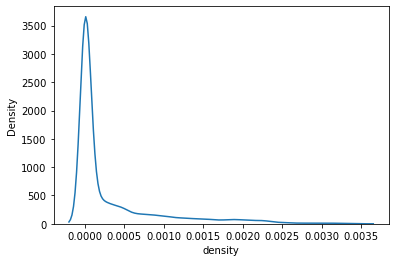

In [4]:
# Dist of density
sns.kdeplot(df.density)

In [39]:
df.density = np.log1p(df.density)

## VIF

In [141]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df.drop('geometry', axis=1).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.drop('geometry', axis=1).values, i)
                          for i in range(len(df.drop('geometry', axis=1).columns))]
  
print(vif_data)

       feature       VIF
0      density  1.808319
1          ATM  1.011414
2          Bus  1.069119
3   Conv_Store  1.294080
4        생활서비스  2.369742
5           소매  1.466402
6        학문/교육  1.438778
7           음식  2.451566
8     관광/여가/오락  1.594024
9          부동산  1.485994
10         스포츠  1.306540
11          숙박  1.046534
12   to_in_001  1.477424


In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df.drop(['geometry','to_in_007','to_in_008'], axis=1).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.drop(['geometry','to_in_007','to_in_008'], axis=1).values, i) for i in range(len(df.drop(['geometry','to_in_007','to_in_008'], axis=1).columns))]
  
print(vif_data)

       feature       VIF
0      density  1.808329
1          ATM  1.011416
2          Bus  1.069108
3   Conv_Store  1.294081
4        생활서비스  2.369766
5           소매  1.466402
6        학문/교육  1.438778
7           음식  2.451570
8     관광/여가/오락  1.594025
9          부동산  1.485994
10         스포츠  1.306540
11          숙박  1.046537
12   to_in_001  1.477363


In [ ]:
# Independent variable cols
df = df.drop(['to_in_007','to_in_008'], axis=1)
var_names = list(df.columns.drop(['geometry','density']))

In [43]:
var_names

['ATM',
 'Bus',
 'Conv_Store',
 '생활서비스',
 '소매',
 '학문/교육',
 '음식',
 '관광/여가/오락',
 '부동산',
 '스포츠',
 '숙박',
 'to_in_001']

### Moran's I

In [44]:
# Get weight matrix
knn = weights.KNN.from_dataframe(df, k=1)
knn.transform = 'r'

In [45]:
# Moran's I
from esda.moran import Moran

I_density = Moran(df.density.values, knn)

In [142]:
I_density.I, I_density.p_sim

(0.998068259906267, 0.001)

In [165]:
Moran_result = []

for var in ['density']+var_names:
    I_var = Moran(df[var].values, knn)
    Moran_result.append([var, I_var.I, I_var.z_sim, I_var.p_sim])

In [168]:
pd.DataFrame(Moran_result, columns=['Variable','I','z-score','p-value'])

,Variable,I,z-score,p-value
0,density,0.998068,225.250569,0.001
1,ATM,0.006614,1.778677,0.046
2,Bus,0.068310,15.592823,0.001
3,Conv_Store,0.119085,28.371243,0.001
4,생활서비스,0.424673,98.177114,0.001
5,소매,0.207225,58.468786,0.001
6,학문/교육,0.306272,69.516582,0.001
7,음식,0.539817,127.205407,0.001
8,관광/여가/오락,0.329660,79.689763,0.001
9,부동산,0.200115,45.005985,0.001


(-1.0, 1.0)

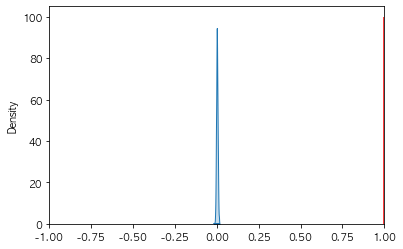

In [151]:
sns.kdeplot(I_density.sim, shade=True)
plt.vlines(I_density.sim, 0, 0.5)
plt.vlines(I_density.I, 0, 100, 'red')
plt.xlim([-1,1])

Text(0, 0.5, 'Spatial Lag of Model Residuals - $Wu$')

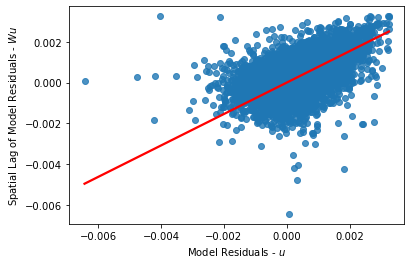

In [27]:
# Spatial Lag residual plot
lag_residual = weights.spatial_lag.lag_spatial(knn, OLS.u)
ax = sns.regplot(
    x= OLS.u.flatten(),
    y= lag_residual.flatten(),
    line_kws={"color":"red"},
    ci=None
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $Wu$")

## OLS

In [50]:
spatial = spreg.OLS(
    # Responsive(Y)
    df.density.values,
    # Predictive(X)
    df[var_names].values,
    # weight
    w = knn, 
    # var names
    name_y = "log_density",
    name_x = var_names,
    spat_diag=True
)

In [51]:
print(spatial.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : log_density                Number of Observations:       54910
Mean dependent var  :      0.0003                Number of Variables   :          13
S.D. dependent var  :      0.0006                Degrees of Freedom    :       54897
R-squared           :      0.3884
Adjusted R-squared  :      0.3883
Sum squared residual:       0.012                F-statistic           :   2905.5807
Sigma-square        :       0.000                Prob(F-statistic)     :           0
S.E. of regression  :       0.000                Log likelihood        :  343009.797
Sigma-square ML     :       0.000                Akaike info criterion : -685993.594
S.E of regression ML:      0.0005                Schwarz criterion     : -685877.719

-----------------------------------------------------------------------------

## Spatially Lagged Exogenous Model
- 공간시차를 둘 변수(spatially lagging variable) : ATM

In [169]:
df

,geometry,density,ATM,Bus,Conv_Store,생활서비스,소매,학문/교육,음식,관광/여가/오락,부동산,스포츠,숙박,to_in_001
0,"POLYGON ((229763.414 299957.480, 229762.899 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,"POLYGON ((229863.454 299957.995, 229862.938 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,"POLYGON ((229963.493 299958.511, 229962.978 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,"POLYGON ((230063.533 299959.027, 230063.017 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,"POLYGON ((230163.572 299959.542, 230163.057 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54905,"POLYGON ((244821.634 328647.621, 244821.115 32...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
54906,"POLYGON ((244921.675 328648.140, 244921.156 32...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
54907,"POLYGON ((245021.716 328648.658, 245021.197 32...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0
54908,"POLYGON ((244821.115 328747.662, 244820.596 32...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [171]:
df_w = df.assign(w_음식 = weights.lag_spatial(knn, df['음식'].values))
df_w = df_w.assign(w_to_in_001 = weights.lag_spatial(knn, df['to_in_001'].values))
df_w.head(5)

,geometry,density,ATM,Bus,Conv_Store,생활서비스,소매,학문/교육,음식,관광/여가/오락,부동산,스포츠,숙박,to_in_001,w_음식,w_to_in_001
0,"POLYGON ((229763.414 299957.480, 229762.899 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,"POLYGON ((229863.454 299957.995, 229862.938 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,"POLYGON ((229963.493 299958.511, 229962.978 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,"POLYGON ((230063.533 299959.027, 230063.017 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,"POLYGON ((230163.572 299959.542, 230163.057 30...",0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0


In [172]:
m_atm = spreg.OLS(
    df_w.density.values,
    df_w[var_names + ['w_음식','w_to_in_001']].values,
    w=knn, spat_diag = True,
    name_x = var_names + ['w_음식','w_to_in_001'],
    name_y = 'log_density'
)

In [173]:
print(m_atm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : log_density                Number of Observations:       54910
Mean dependent var  :      0.0003                Number of Variables   :          15
S.D. dependent var  :      0.0006                Degrees of Freedom    :       54895
R-squared           :      0.4539
Adjusted R-squared  :      0.4538
Sum squared residual:       0.011                F-statistic           :   3259.6863
Sigma-square        :       0.000                Prob(F-statistic)     :           0
S.E. of regression  :       0.000                Log likelihood        :  346120.861
Sigma-square ML     :       0.000                Akaike info criterion : -692211.722
S.E of regression ML:      0.0004                Schwarz criterion     : -692078.020

-----------------------------------------------------------------------------

## Spatially Lagged Endogenous Model

In [55]:
m_endo = spreg.GM_Lag(
    np.log1p(df.density.values),
    df[var_names].values,
    w=knn, spat_diag = True,
    name_y = 'log_density',
    name_x = var_names
)

In [56]:
print(m_endo.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : log_density                Number of Observations:       54910
Mean dependent var  :      0.0003                Number of Variables   :          14
S.D. dependent var  :      0.0006                Degrees of Freedom    :       54896
Pseudo R-squared    :      0.9963
Spatial Pseudo R-squared:  0.2757

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.0000007       0.0000002       3.0229627       0.0025031
                 ATM       0.0000030       0.0000017       1.7943364       0.0727595
                 Bus       0.0000023       0.0000006       

## Prediction

In [174]:
grid_sj = gpd.read_file('data/CENSUS/grid_SJ_100M.gpkg') # load grid_sj information

# census data
census = gpd.read_file('df_full_100M.gpkg').fillna(0)
df_sj = grid_sj.set_index('GRID_100M_').join(census[census.columns.drop('geometry')].set_index('GRID_100M_')).reset_index(drop=True)

In [182]:
knn_sj = weights.KNN.from_dataframe(df_sj)
df__sj_w = df_sj.assign(w_음식 = weights.lag_spatial(knn_sj, df_sj['음식'].values))
df__sj_w = df__sj_w.assign(w_to_in_001 = weights.lag_spatial(knn_sj, df_sj['to_in_001'].values))

In [183]:
res_m_atm = pd.DataFrame()
res_m_atm['Variable'] = m_atm.name_x
res_m_atm['beta'] = m_atm.betas
res_m_atm['pval'] = [round(j,5) for i,j in m_atm.t_stat]
res_m_atm = res_m_atm.loc[res_m_atm.pval < 0.05,:]
res_m_atm

,Variable,beta,pval
0,CONSTANT,0.000185,0.00000
1,ATM,0.000280,0.00000
2,Bus,0.000130,0.00000
3,Conv_Store,0.000115,0.00000
4,생활서비스,0.000090,0.00000
5,소매,0.000004,0.00000
6,학문/교육,-0.000019,0.00000
7,음식,0.000019,0.00000
9,부동산,0.000025,0.00011
10,스포츠,0.000028,0.02813


In [184]:
# calculate predicted density

df__sj_w['density'] = 0.0
df__sj_w.density += res_m_atm.beta[0]

for var, b, p in res_m_atm.values:
    if var == 'CONSTANT':
        pass
    else:
        df__sj_w.density += df__sj_w.loc[:,var] * b

In [185]:
df__sj_w.density = (df__sj_w.density - df__sj_w.density.mean()) / df__sj_w.density.std() # standardize

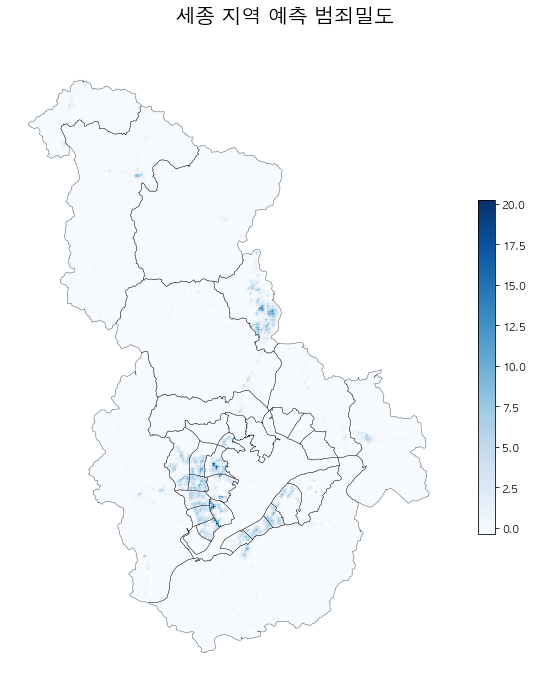

In [188]:
# Prediction map
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949').to_crs(epsg=5181)
crime_sejong = gpd.read_file('data/gdf_crime_adm_SJ.gpkg')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
sejong.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.3)
df__sj_w.plot(column = 'density',ax=ax, zorder=1, cmap='Blues', legend=True, legend_kwds={'shrink' : 0.5})
# crime_sejong.geometry.plot(ax=ax, zorder=3, color='red', markersize=0.5)

ax.set_axis_off()

plt.suptitle('세종 지역 예측 범죄밀도', fontsize=20)
plt.tight_layout()
plt.show()

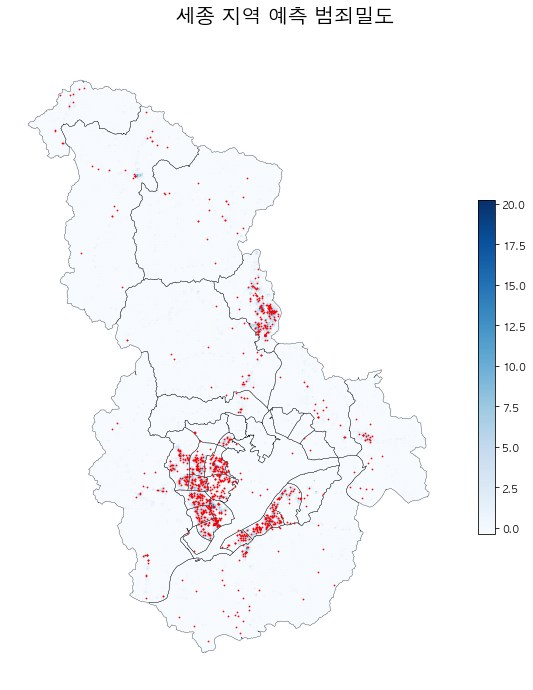

In [197]:
# Prediction map
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949').to_crs(epsg=5181)
crime_sejong = gpd.read_file('data/gdf_crime_adm_SJ.gpkg')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
sejong.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.3)
df__sj_w.plot(column = 'density',ax=ax, zorder=1, cmap='Blues', legend=True, legend_kwds={'shrink' : 0.5})
crime_sejong.geometry.plot(ax=ax, zorder=3, color='red', markersize=0.5)

ax.set_axis_off()

plt.suptitle('세종 지역 예측 범죄밀도', fontsize=20)
plt.tight_layout()
plt.show()

## Accuracy
전체 세종시 보이스피싱 범죄 $1422$건 중 $1158$건이 density prediction으로 얻어진 격자($N=4200$)에 포함됨</br>
오차 포함시(격자 중심부(`centroid`)로부터 $100$m 이내) 총 $1307$건
$$
Recall \simeq 0.8 \;\; (0.92\;\text{if 100m error})
$$

In [202]:
len(grid_sj)

47377

In [193]:
plus_densities = df__sj_w[df__sj_w.density > 0]
len(plus_densities)

4200

In [194]:
crime_grid_idx = crime_sejong.sjoin(df__sj_w)['index_right']
len(crime_grid_idx) # 전체 범죄 수

1422

In [198]:
sum([i in plus_densities.index for i in crime_grid_idx]) / 1422

0.8143459915611815

In [196]:
contained = 0
for i in range(len(crime_sejong)):
    arr = np.where(plus_densities.centroid.distance(crime_sejong.geometry[i]) < 100)[0]
    if len(arr) > 0:
        contained += 1
print(contained)

1307


(-1.0, 20.0)

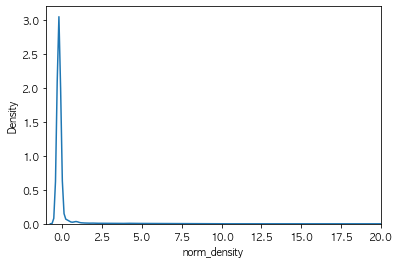

In [201]:
sns.kdeplot(df__sj_w.density)
plt.xlabel('norm_density')
plt.grid(visible=False)
plt.xlim([-1,20])